In [1]:
%%capture
!unzip /content/drive/MyDrive/train.zip -d /content/train

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, random_split, DataLoader

from torchvision import transforms

from PIL import Image
import glob
import numpy as np
import cv2
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

from google.colab.patches import cv2_imshow

%matplotlib inline 

In [3]:
class VKStickerDataset(nn.Module):
    def __init__(self, img_dir, size, center_crop=False):
        super().__init__()
        self.images = glob.glob(img_dir)
        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )
        self.size = size

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        im = cv2.imread(self.images[idx], cv2.IMREAD_UNCHANGED)
        im = cv2.resize(im, (self.size, self.size))
        ret, mask = cv2.threshold(im[:, :, 3], 0, 255, cv2.THRESH_BINARY)

        mask[mask == 255] = 1
        mask[mask == 0] = 0

        rgb_im = cv2.cvtColor(im, cv2.COLOR_RGBA2RGB)

        rgb_im = torch.Tensor(rgb_im).permute(2, 0, 1)
        mask = torch.Tensor(mask)

        return (rgb_im, mask)

In [4]:
SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    # outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.type(torch.IntTensor).to("cpu")
    outputs = outputs.to("cpu")
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded 

In [5]:
files = glob.glob("/content/train/downloaded/*/*.webp")

for f in files:
    img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    try:
        r, g, b, a = cv2.split(img)
    except Exception as e:
        os.remove(f)

In [6]:
EPOCHS = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
data_path = "/content/train/downloaded/*/*.webp"

dataset = VKStickerDataset(data_path, size=256)
train_dataset, val_dataset = random_split(dataset, [0.7, 0.3])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

print(f"Train dataset: {len(train_dataset)}, Val dataset: {len(val_dataset)}")

Train dataset: 5361, Val dataset: 2297


## UNET

In [ ]:
model = torch.load("/content/drive/MyDrive/unet_tuned.pt").to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
for epoch in range(EPOCHS):
    print(f"EPOCH #{epoch}")
    model.train()
    
    train_loss = torch.Tensor([])
    for x, y in tqdm(train_dataloader):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss = torch.cat((train_loss, torch.Tensor([loss.to("cpu")])), dim=0)
    
    avg_train_loss = sum(train_loss) / len(train_loss)

    model.eval()
    val_loss = torch.Tensor([])
    val_iou = torch.Tensor([])

    with torch.no_grad():
        for x, y in tqdm(val_dataloader):
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, y)

            val_loss = torch.cat((val_loss, torch.Tensor([loss.to("cpu")])), dim=0)

            outputs = torch.sigmoid(outputs) > 0.5

            i_o_u = iou_pytorch(outputs, y)
            val_iou = torch.cat((val_iou, i_o_u), dim=0)
    
    avg_val_loss = sum(val_loss) / len(val_loss)
    avg_iou = sum(val_iou) / len(val_iou)

    print(f"train_loss: {avg_train_loss}, \
            val_loss: {avg_val_loss}, \
            iou_score: {avg_iou}")

19 epoch: train_loss: 0.4740603268146515,             val_loss: 0.4751051366329193,             dice_score: 0.8696250915527344

In [ ]:
torch.save(model, "/content/drive/MyDrive/unet_tuned.pt")

## SegFormer

In [8]:
%%capture
!pip install transformers

In [9]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests

In [10]:
image_processor = AutoImageProcessor.from_pretrained("nvidia/mit-b0")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0", num_labels=2, ignore_mismatched_sizes=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linea

In [11]:
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.BCEWithLogitsLoss()

# check samples


In [21]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

torch.Size([1, 256, 256])


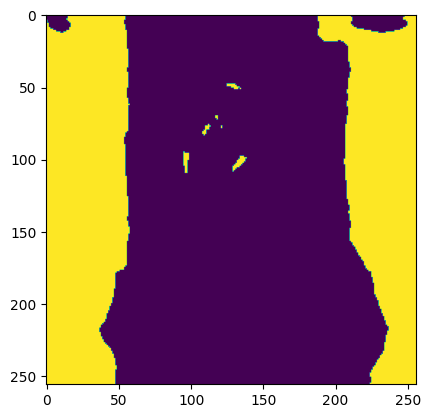

In [30]:
img = Image.open("/content/train/downloaded/adrianochelentano/0.webp").convert("RGB")
img = image_processor(img, return_tensors="pt")
outputs = model(**img).logits
outputs = nn.functional.interpolate(outputs, size=(256, 256), mode="bilinear", align_corners=False)

outputs = outputs.argmax(dim=1)
print(outputs.size())
outputs = outputs.permute(1, 2, 0).detach().numpy()

plt.imshow(outputs)
plt.show()

# tuning

In [ ]:
for epoch in range(EPOCHS):
    print(f"EPOCH #{epoch}")
    model.train()
    
    train_loss = torch.Tensor([])
    for x, y in tqdm(train_dataloader):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.type(torch.LongTensor).to(device)

        outputs = model(pixel_values=x, labels=y)
        loss, logits = outputs["loss"], outputs["logits"]
        loss.backward()
        optimizer.step()

        train_loss = torch.cat((train_loss, torch.Tensor([loss.to("cpu")])), dim=0)
    
    avg_train_loss = sum(train_loss) / len(train_loss)

    model.eval()
    val_loss = torch.Tensor([])
    val_iou = torch.Tensor([])

    with torch.no_grad():
        for x, y in tqdm(val_dataloader):
            x = x.to(device)
            y = y.type(torch.LongTensor).to(device)

            outputs = model(pixel_values=x, labels=y)
            loss, logits = outputs["loss"], outputs["logits"]

            val_loss = torch.cat((val_loss, torch.Tensor([loss.to("cpu")])), dim=0)

            upsampled_logits = nn.functional.interpolate(logits, size=y.shape[-2:], mode="bilinear", align_corners=False)
            outputs = upsampled_logits.argmax(dim=1)

            i_o_u = iou_pytorch(outputs, y)
            val_iou = torch.cat((val_iou, i_o_u), dim=0)
    
    avg_val_loss = sum(val_loss) / len(val_loss)
    avg_iou = sum(val_iou) / len(val_iou)

    print(f"train_loss: {avg_train_loss}, \
            val_loss: {avg_val_loss}, \
            iou_score: {avg_iou}")
    if epoch % 20 == 0 and epoch != 0:
      torch.save(model, f"/content/drive/MyDrive/seg/model{epoch}.pt")

EPOCH #0


100%|██████████| 144/144 [00:21<00:00,  6.77it/s]


train_loss: 0.14448611438274384,             val_loss: 0.07455103099346161,             iou_score: 0.9660007953643799
EPOCH #1


100%|██████████| 144/144 [00:21<00:00,  6.81it/s]


train_loss: 0.07025740295648575,             val_loss: 0.05918698012828827,             iou_score: 0.9740981459617615
EPOCH #2


100%|██████████| 144/144 [00:21<00:00,  6.80it/s]


train_loss: 0.05726171284914017,             val_loss: 0.05175013840198517,             iou_score: 0.9787999391555786
EPOCH #3


100%|██████████| 144/144 [00:21<00:00,  6.58it/s]


train_loss: 0.0519905649125576,             val_loss: 0.04901684448122978,             iou_score: 0.9806719422340393
EPOCH #4


100%|██████████| 144/144 [00:21<00:00,  6.66it/s]


train_loss: 0.04770728573203087,             val_loss: 0.04478743299841881,             iou_score: 0.9839799404144287
EPOCH #5


100%|██████████| 144/144 [00:21<00:00,  6.65it/s]


train_loss: 0.04412773251533508,             val_loss: 0.04302726686000824,             iou_score: 0.9850684404373169
EPOCH #6


100%|██████████| 144/144 [00:21<00:00,  6.66it/s]


train_loss: 0.04102896898984909,             val_loss: 0.0417303666472435,             iou_score: 0.985590934753418
EPOCH #7


100%|██████████| 144/144 [00:21<00:00,  6.76it/s]


train_loss: 0.04091382399201393,             val_loss: 0.046231333166360855,             iou_score: 0.9817160367965698
EPOCH #8


100%|██████████| 144/144 [00:21<00:00,  6.69it/s]


train_loss: 0.03965848311781883,             val_loss: 0.040626976639032364,             iou_score: 0.9862438440322876
EPOCH #9


100%|██████████| 144/144 [00:21<00:00,  6.66it/s]


train_loss: 0.03607868403196335,             val_loss: 0.038283366709947586,             iou_score: 0.9878544807434082
EPOCH #10


100%|██████████| 144/144 [00:22<00:00,  6.46it/s]


train_loss: 0.03466745465993881,             val_loss: 0.03627639263868332,             iou_score: 0.9897260069847107
EPOCH #11


100%|██████████| 144/144 [00:22<00:00,  6.47it/s]


train_loss: 0.03426904231309891,             val_loss: 0.041014473885297775,             iou_score: 0.9874191880226135
EPOCH #12


100%|██████████| 144/144 [00:22<00:00,  6.42it/s]


train_loss: 0.03526882454752922,             val_loss: 0.03493065387010574,             iou_score: 0.990161657333374
EPOCH #13


100%|██████████| 144/144 [00:22<00:00,  6.39it/s]


train_loss: 0.03156139329075813,             val_loss: 0.0347796231508255,             iou_score: 0.9908145070075989
EPOCH #14


100%|██████████| 144/144 [00:22<00:00,  6.37it/s]


train_loss: 0.0306486114859581,             val_loss: 0.03421523794531822,             iou_score: 0.9906401634216309
EPOCH #15


100%|██████████| 144/144 [00:22<00:00,  6.41it/s]


train_loss: 0.029456010088324547,             val_loss: 0.03301239386200905,             iou_score: 0.9912499189376831
EPOCH #16


100%|██████████| 144/144 [00:22<00:00,  6.47it/s]


train_loss: 0.029480066150426865,             val_loss: 0.03345869481563568,             iou_score: 0.9908581972122192
EPOCH #17


100%|██████████| 144/144 [00:22<00:00,  6.36it/s]


train_loss: 0.02781566046178341,             val_loss: 0.032046183943748474,             iou_score: 0.9921205639839172
EPOCH #18


100%|██████████| 144/144 [00:22<00:00,  6.53it/s]


train_loss: 0.02725789323449135,             val_loss: 0.031633149832487106,             iou_score: 0.9918593764305115
EPOCH #19


100%|██████████| 144/144 [00:21<00:00,  6.58it/s]


train_loss: 0.026674281805753708,             val_loss: 0.030750831589102745,             iou_score: 0.9925124049186707
EPOCH #20


100%|██████████| 144/144 [00:21<00:00,  6.56it/s]


train_loss: 0.03302273526787758,             val_loss: 0.030682720243930817,             iou_score: 0.9923818707466125
EPOCH #21


100%|██████████| 144/144 [00:21<00:00,  6.66it/s]


train_loss: 0.026526493951678276,             val_loss: 0.030082128942012787,             iou_score: 0.9926866292953491
EPOCH #22


100%|██████████| 144/144 [00:21<00:00,  6.64it/s]


train_loss: 0.024998832494020462,             val_loss: 0.029718764126300812,             iou_score: 0.993426501750946
EPOCH #23


100%|██████████| 144/144 [00:21<00:00,  6.67it/s]


train_loss: 0.024780582636594772,             val_loss: 0.030141284689307213,             iou_score: 0.99338299036026
EPOCH #24


100%|██████████| 144/144 [00:21<00:00,  6.73it/s]


train_loss: 0.024334203451871872,             val_loss: 0.029359737411141396,             iou_score: 0.9930780529975891
EPOCH #25


100%|██████████| 144/144 [00:21<00:00,  6.77it/s]


train_loss: 0.023584585636854172,             val_loss: 0.027877211570739746,             iou_score: 0.9940359592437744
EPOCH #26


100%|██████████| 144/144 [00:21<00:00,  6.75it/s]


train_loss: 0.023306898772716522,             val_loss: 0.029880745336413383,             iou_score: 0.992860734462738
EPOCH #27


100%|██████████| 144/144 [00:21<00:00,  6.70it/s]


train_loss: 0.022860607132315636,             val_loss: 0.02870398387312889,             iou_score: 0.9932523965835571
EPOCH #28


100%|██████████| 144/144 [00:21<00:00,  6.81it/s]


train_loss: 0.023221485316753387,             val_loss: 0.028520919382572174,             iou_score: 0.9934700727462769
EPOCH #29


100%|██████████| 144/144 [00:21<00:00,  6.78it/s]


train_loss: 0.025852112099528313,             val_loss: 0.027521511539816856,             iou_score: 0.9935135245323181
EPOCH #30


100%|██████████| 144/144 [00:21<00:00,  6.75it/s]


train_loss: 0.022076275199651718,             val_loss: 0.02753114141523838,             iou_score: 0.9939053058624268
EPOCH #31


100%|██████████| 144/144 [00:21<00:00,  6.72it/s]


train_loss: 0.021842770278453827,             val_loss: 0.027150563895702362,             iou_score: 0.9940794110298157
EPOCH #32


100%|██████████| 144/144 [00:21<00:00,  6.61it/s]


train_loss: 0.022392230108380318,             val_loss: 0.027477599680423737,             iou_score: 0.9942536354064941
EPOCH #33


100%|██████████| 144/144 [00:21<00:00,  6.61it/s]


train_loss: 0.021158387884497643,             val_loss: 0.026849865913391113,             iou_score: 0.993948757648468
EPOCH #34


100%|██████████| 144/144 [00:21<00:00,  6.70it/s]


train_loss: 0.02039540372788906,             val_loss: 0.027335776016116142,             iou_score: 0.993818461894989
EPOCH #35


100%|██████████| 144/144 [00:21<00:00,  6.70it/s]


train_loss: 0.020237145945429802,             val_loss: 0.026935014873743057,             iou_score: 0.9945148825645447
EPOCH #36


100%|██████████| 144/144 [00:21<00:00,  6.72it/s]


train_loss: 0.019853102043271065,             val_loss: 0.026757510378956795,             iou_score: 0.9943406581878662
EPOCH #37


100%|██████████| 144/144 [00:21<00:00,  6.73it/s]


train_loss: 0.019892236217856407,             val_loss: 0.02881496399641037,             iou_score: 0.9930781722068787
EPOCH #38


100%|██████████| 144/144 [00:21<00:00,  6.71it/s]


train_loss: 0.0200493186712265,             val_loss: 0.027279319241642952,             iou_score: 0.9944711923599243
EPOCH #39


100%|██████████| 144/144 [00:21<00:00,  6.68it/s]


train_loss: 0.01983669213950634,             val_loss: 0.027473976835608482,             iou_score: 0.9937746524810791
EPOCH #40


100%|██████████| 144/144 [00:21<00:00,  6.71it/s]


train_loss: 0.019395366311073303,             val_loss: 0.027005590498447418,             iou_score: 0.9943841099739075
EPOCH #41


100%|██████████| 144/144 [00:21<00:00,  6.69it/s]


train_loss: 0.01907357946038246,             val_loss: 0.029655950143933296,             iou_score: 0.993252158164978
EPOCH #42


100%|██████████| 144/144 [00:21<00:00,  6.77it/s]


train_loss: 0.019993580877780914,             val_loss: 0.026568258181214333,             iou_score: 0.993948757648468
EPOCH #43


100%|██████████| 144/144 [00:21<00:00,  6.77it/s]


train_loss: 0.019099637866020203,             val_loss: 0.026424465700984,             iou_score: 0.9942535161972046
EPOCH #44


100%|██████████| 144/144 [00:21<00:00,  6.77it/s]


train_loss: 0.022440332919359207,             val_loss: 0.02672889456152916,             iou_score: 0.9939489960670471
EPOCH #45


 74%|███████▍  | 249/336 [01:00<00:19,  4.35it/s]